<a href="https://colab.research.google.com/github/francobarrionuevoenv21/PaddyFieldStaFe_Segm_UNETs_public/blob/main/L8_data_chipping_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

### About the Project

The project consisted in training a Convolutional Neural Network to detect active/in-production paddy fields in Santa Fe province, Argentina. This area was originally characterized by wetlands, but in recent decades these natural ecosystems have been converted into paddy fields.

The approach will involve training a basic [U-Net neural network](https://www.geeksforgeeks.org/machine-learning/u-net-architecture-explained/) along with two variations. These variations will use different backbones and pretrained weights.

### Data

The data used in this project consists of [Landsat 8 (L8) composite scenes (corrected to surface reflectance)](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=es-419) for the period November–February. This corresponds to the stage in which the paddy fields of the study area—a wetland region in center Santa Fe (Argentina)—reach full development before harvesting. During this period, the crop is easier to identify in optical imagery and typically shows a strong NDVI peak associated with maximum biomass.

The L8 images were obtained from the Google Earth Engine platform. To reduce file size, only the R, G, B and NIR bands were included. In total, 12 images were retrieved, one for each year between 2014 and 2025. For example, to obtain the scene for 2019, the composite was generated using the period from November 2018 to February 2019, and so on.

### Notebook Description

In this notebook, the processing of the L8 scenes is performed to prepare them as input for the CNN models. First, the NDVI index is computed. Then, the image and mask chips are generated. The ground truth for each year corresponds to a vector layer with clusters of paddy fields differentiated by active year, which was generated and validated as previous work.

# Code Development

**NOTE**: The following code performs the processing of individual composite scenes. For each L8 image obtained the same steps were applied

In [ ]:
## INSTALL DEPENDENCIES AND IMPORT LIBRARIES
import geopandas as gpd
!pip install rasterio
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import files

In [ ]:
# INSTALL PYSATPROC FOR IMAGES CHIPPING AND MASKS GENERATION
!pip install pysatproc

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pysatproc: filename=pysatproc-0.1.9-py2.py3-none-any.whl size=35821 sha256=2d165e2d60e4d5d40e2cc281ec5a5b974278fdce76885f81fa04700c7c2e6424
  Stored in directory: /root/.cache/pip/wheels/7c/16/5a/48caeb076fd4c56687489ae62b8ab6de28db1708285d5f995a
Successfully built pysatproc


In [ ]:
# UNZIP FOLDER WITH THE L8 SCENES BY YEAR

## SET FILE PATH AND CREATE OUTPUT FOLDER
zip_file_path = '...'
destination_folder = '/content/l8_scenes'
os.makedirs(destination_folder, exist_ok=True) # Create the destination folder if it doesn't exist

## UNZIP THE COMPRESSED FILE IN THE DESTINATION
!unzip -q {zip_file_path} -d {destination_folder}

In [ ]:
## SET FILE PATH AND CREATE OUTPUT FOLDER FOR IMAGES + NDVI
destination_folder_02 = '/content/l8_scenes_wNDVI'
os.makedirs(destination_folder_02, exist_ok=True)

##Scene Selection

**NOTE**: To select the scene corresponding to the year Y, it has to be set a Previous Year (prev_year) as Y-1, Analisys Year (anls_year) as Y in string format

In [ ]:
prev_year = "2021"
anls_year = "2022"

## Data Processing and Chips Generation

###Raster Processing

In [ ]:
# OPEN L8 SCENE IN RASTER FILE
tif_path = f'/content/l8_scenes/L8_comp_clipped_{prev_year[-2:]}to{anls_year[-2:]}_int16.tif'
tif = rasterio.open(tif_path)

# OPEN THE L8 SCENE WITH THE R, G, B, AND NIR BANDS AND COMPUTE NDVI INDEX
infile = tif_path # RGB + NIR raster path
outfile = f"{destination_folder_02}/{tif_path[19:-10]}_with_NDVI.tif"

# Read input file
with rasterio.open(infile) as src:
    profile = src.profile.copy()
    red  = src.read(3).astype("float32")  # Landsat 8 RED = band
    nir  = src.read(4).astype("float32")  # Landsat 8 NIR = band
    bands = src.read()                    # read all original bands

# Calculate NDVI
ndvi = (nir - red) / (nir + red + 1e-10)  # add epsilon to avoid /0

# Update profile
profile.update(
    count = bands.shape[0] + 1,   # add NDVI as new band
    dtype = "float32"
)

# Write the output with the NDVI band
with rasterio.open(outfile, "w", **profile) as dst:
    # write original bands
    for i in range(bands.shape[0]):
        dst.write(bands[i], i + 1)

    # write NDVI as last band
    dst.write(ndvi.astype("float32"), bands.shape[0] + 1)

# OPEN THE CREATED RASTER FOR LATER VISUALIZATION
tif_wNDVI = rasterio.open(outfile)

In [ ]:
# DEFINE A FUNCTION TO PROCESS RGB BANDS FOR VISUALIZATION
def bands_norm_rgb(tif_proc):
  '''
  This function takes as input the raster file with the NDVI band, and returns
  a stack of the RGB bands normalized (but no equalized) for visualization
  '''
  red_band = tif_wNDVI.read(1)
  green_band = tif_wNDVI.read(2)
  blue_band = tif_wNDVI.read(3)

  rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

  for i in range(rgb_image.shape[-1]):
    band_min, band_max = rgb_image[:,:,i].min(), rgb_image[:,:,i].max()
    rgb_image[:,:,i] = ((rgb_image[:,:,i] - band_min) / (band_max - band_min)) * 255

  return rgb_image.astype(np.uint8)

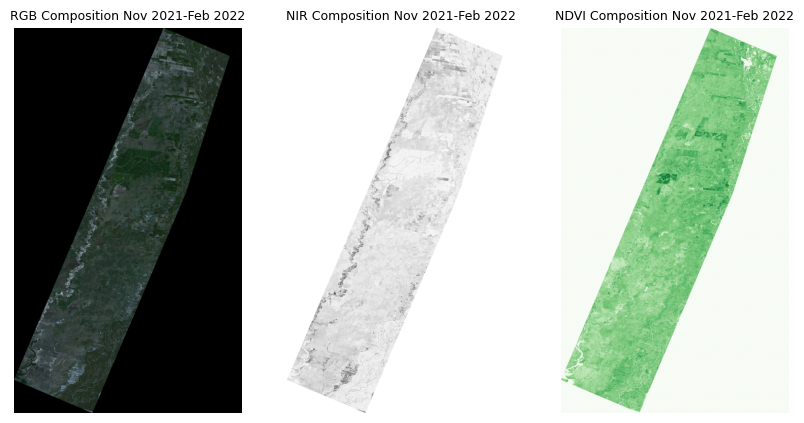

In [ ]:
# VISUALIZE IMAGE BANDS

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

## RGB
axs[0].imshow(bands_norm_rgb(tif_wNDVI))
axs[0].set_title(f'RGB Composition Nov {prev_year}-Feb {anls_year}', fontsize=9)
axs[0].axis('off')

## NIR
axs[1].imshow(tif_wNDVI.read(3), cmap='Grays')
axs[1].set_title(f'NIR Composition Nov {prev_year}-Feb {anls_year}', fontsize=9)
axs[1].axis('off')

## NDVI
axs[2].imshow(tif_wNDVI.read(4), cmap='Greens')
axs[2].set_title(f'NDVI Composition Nov {prev_year}-Feb {anls_year}', fontsize=9)
axs[2].axis('off')

plt.show()

### Chips and Masks Generation

#### Loading and Processing Grund Truth Data

**NOTE**: As mentioned before, the ground truth for each year corresponds to a vector layer with clusters of paddy fields differentiated by active year, which was generated and validated as previous work. This will use as input for masks creation.

In [ ]:
# OPEN VECTOR FILE WITH ACTIVE PADDY FIELDS IDENTIFIED BY YEAR
path_vector = '/content/05_ArrocerasBBSS_discriminadasIni&Fin_Junio2024v03.geojson'
gdf_paddyfields = gpd.read_file(path_vector)

## Visualize geodataframe
gdf_paddyfields.head()

,ID_arroc,anio_ini,anio_fin,geometry
0,16,2004,2022,"MULTIPOLYGON (((-59.97516 -30.41397, -59.97499..."
1,8,2009,2022,"MULTIPOLYGON (((-60.16691 -30.7328, -60.16682 ..."
2,3,2005,2018,"MULTIPOLYGON (((-60.07641 -30.34001, -60.07638..."
3,8,2009,2022,"MULTIPOLYGON (((-60.15344 -30.70537, -60.15354..."
4,12,2012,2021,"MULTIPOLYGON (((-60.07945 -30.42096, -60.07945..."


In [ ]:
# FILTER PADDY FIELDS AND SELECT THOSE ACTIVE IN THE YEAR OF ANALYSIS
if int(prev_year) == 2021:
  gdf_paddyfields_filt = gdf_paddyfields[(gdf_paddyfields['anio_fin'] == int(anls_year))].copy()
else:
  gdf_paddyfields_filt = gdf_paddyfields[(gdf_paddyfields['anio_ini'] <= int(anls_year)) & (gdf_paddyfields['anio_fin'] > int(anls_year))].copy()

# ASSIGN A CLASS NUMBER FOR FOLLOWING CHIPS AND MASKS CREATION
gdf_paddyfields_filt['class'] = 1

# SAVE THE GDF FOR FOLLOWING STEPS

## Create the folder for the files
destination_folder_03 = '/content/Pfields_filt_geojson'
os.makedirs(destination_folder_03, exist_ok=True) # if it doesn't exist

## Save the file
fpath_gdf = f'{destination_folder_03}/gdf_{anls_year}.geojson'
gdf_paddyfields_filt.to_file(fpath_gdf, driver='GeoJSON')

#### Chips and Masks Generation with *pysatproc*

**NOTE**: Chips and masks created are 128x128 (size 128) pixels with 50% overlapping (step-size 64). The generation is based on active paddy fields according to the ground thruth layer.

In [ ]:
# GENERATION OF CHIPS AND MASKS FOR THE YEAR OF ANALYSIS

## Define path for the chips
fpath_foldChips = f'/content/chips_{anls_year}_128px'

## Define the command in str format
command_str = f"""satproc_extract_chips \
    {outfile} \
    -o {fpath_foldChips} \
    --size 128 \
    --step-size 64 \
    --aoi {fpath_gdf} \
    --labels {fpath_gdf} \
    --label-property 'class' \
    --classes 1 \
    --masks 'extent' \
    --rescale \
    --rescale-mode percentiles \
    --upper-cut 98 --lower-cut 2
"""

!{command_str} ## Run the command

# COMMENTS
'''
--rescale-mode percentiles
Normalize reflectance values based on percentile stretching of pixel intensities.

--upper-cut and --lower-cut
Used only when --rescale-mode percentiles is selected.

  --lower-cut 2  → map the 2nd percentile to value = 0
  --upper-cut 98 → map the 98th percentile to value = 1
'''

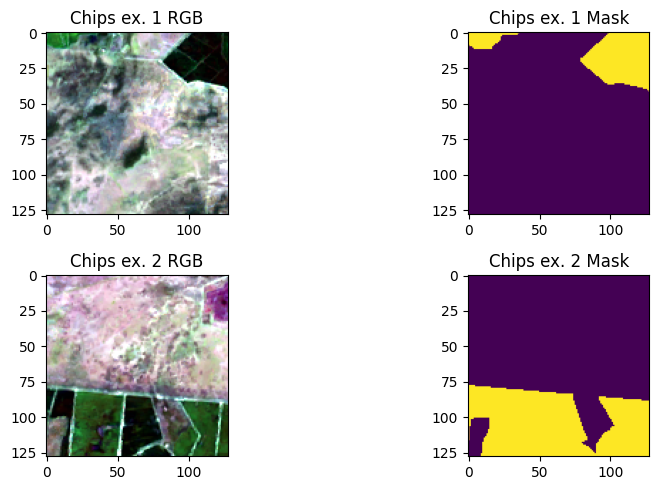

In [ ]:
# VISUALIZE CHIPS EXAMPLES

## Example 1
path_ex01 = 'L8_comp_clipped_21to22_with_NDVI_21_28.tif'
path_ex01_img = '/content/chips_2022_128px/images/' + path_ex01
path_ex01_mask =  '/content/chips_2022_128px/extent/'+ path_ex01

## Example 2
path_ex02 = 'L8_comp_clipped_21to22_with_NDVI_22_22.tif'
path_ex02_img = '/content/chips_2022_128px/images/' + path_ex02
path_ex02_mask = '/content/chips_2022_128px/extent/'+ path_ex02

## VISUALIZE EXAMPLES
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

## Example 01
axs[0, 0].imshow(rasterio.open(path_ex01_img).read().transpose(1, 2, 0)[:,:,:3])
axs[0, 0].set_title('Chips ex. 1 RGB')
axs[0, 1].imshow(rasterio.open(path_ex01_mask).read().transpose(1, 2, 0))
axs[0, 1].set_title('Chips ex. 1 Mask')

## Example 02
axs[1, 0].imshow(rasterio.open(path_ex02_img).read().transpose(1, 2, 0)[:,:,:3])
axs[1, 0].set_title('Chips ex. 2 RGB')
axs[1, 1].imshow(rasterio.open(path_ex02_mask).read().transpose(1, 2, 0))
axs[1, 1].set_title('Chips ex. 2 Mask')

plt.tight_layout()

plt.show()

In [ ]:
# ZIP THE FOLDER WITH CHIPS AND MASKS AND DOWNLOAD FOR LATER MERGING

## Define paths
folder_to_download = fpath_foldChips
zip_file_name = f'{fpath_foldChips[9:]}.zip'

## Zip the folder and download
if os.path.exists(folder_to_download):
    !zip -r {zip_file_name} {folder_to_download}
    files.download(zip_file_name)
else:
    print(f"The folder {folder_to_download} does not exist.")